#### Updates
1. Normalize data
2. Add traffic, char length, contact date

In [1]:
import os
import re
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix,precision_score, recall_score,accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def print_accuracy(y_true, y_pred):
    print(confusion_matrix(y_true,y_pred))
    print("precision:", precision_score(y_true,y_pred))
    print("recall:", recall_score(y_true,y_pred))

In [5]:
def plot_coefs(df, top_features=20):
    df_sorted = df.sort_values(by="coef", ascending = False)
    top_positive_coefs = df_sorted[:top_features]
    top_negative_coefs = df_sorted[-top_features:]
    top_coefs = pd.concat([top_positive_coefs,top_negative_coefs], axis = 0).sort_values(by="coef")
    # create plot
    plt.figure(figsize=(20, 5))
    top_coefs['coef'].plot(kind="bar")
    plt.show()

In [6]:
train_test_cross_df = pd.read_csv(r"../data/train_more.txt",sep="|")
eval_df = pd.read_csv(r"../data/eval_more.txt",sep="|")
print(train_test_cross_df.shape, eval_df.shape)
train_test_cross_df[:3]

(4940, 10) (770, 10)


,Unnamed: 0,ID,REMARKS,BAD,SEX_CODE_CD,RACE_CODE_CD,DISTRICT,TRAFFIC,HOTSPOT,POST403
0,0,3736142,"""R/O's observed above subject with two other s...",1,F,BLK,02,0,1,0
1,1,3761761,"""LOITERING IN CITGO GAS STATION, FIELD INTERVI...",0,M,BLK,45,0,0,0
2,2,3746471,"""SUBJECT, A KNOWN LA RAZA GANG MEMBER, WAS LOI...",1,M,WWH,12,0,0,0


In [7]:
# Remove NAs
train_test_cross_df2 = train_test_cross_df[~pd.isnull(train_test_cross_df['REMARKS'])]
eval_df2 = eval_df[~pd.isnull(eval_df['REMARKS'])]
train_test_cross_df2.set_index("ID",inplace=True)
eval_df2.set_index("ID",inplace=True)
print(train_test_cross_df2.shape, eval_df2.shape)

(4877, 9) (759, 9)


In [8]:
print(train_test_cross_df2["BAD"].value_counts())
print(eval_df2["BAD"].value_counts())

0    2772
1    2105
Name: BAD, dtype: int64
0    385
1    374
Name: BAD, dtype: int64


In [9]:
train_test_cross_df2[:2]

,Unnamed: 0,REMARKS,BAD,SEX_CODE_CD,RACE_CODE_CD,DISTRICT,TRAFFIC,HOTSPOT,POST403
ID,,,,,,,,,
3736142,0,"""R/O's observed above subject with two other s...",1,F,BLK,02,0,1,0
3761761,1,"""LOITERING IN CITGO GAS STATION, FIELD INTERVI...",0,M,BLK,45,0,0,0


#### Split into train, test, cross_validation

In [10]:
train_test_X, cross_X, train_test_y, cross_y = train_test_split(train_test_cross_df2,train_test_cross_df2['BAD'], test_size = 0.2)
print(train_test_X.shape, cross_X.shape)

(3901, 9) (976, 9)


In [11]:
train_X, test_X, train_y, test_y = train_test_split(train_test_X, train_test_y, test_size=0.25)
print(train_X.shape, test_X.shape, cross_X.shape)

(2925, 9) (976, 9) (976, 9)


#### Customize transformer

In [12]:
class RemarksExtractor(TransformerMixin, BaseEstimator):

    def __init__(self, factor, replace_num=False):
        self.factor = factor
        self.replace_num = replace_num
    
    def transform(self, X, y=None, **fit_params):
        if self.replace_num:
            processed = X[self.factor].apply(lambda x: re.sub("[0-9]+","numberph",x))
        else:
            processed = X[self.factor]
            
#         print(pd.DataFrame(processed)[:3])
        return processed
        
    def fit(self, X, y=None, **fit_params):
        return self

In [13]:
class VarExtractor(TransformerMixin, BaseEstimator):

    def __init__(self, factor):
        self.factor = factor
    
    def transform(self, X, y=None, **fit_params):
        return pd.DataFrame(X[self.factor])
        
    def fit(self, X, y=None, **fit_params):
        return self

In [14]:
test = pd.DataFrame([1,2])
sq = np.square(test)
pd.concat([test,sq],axis = 1)

,0,0
0,1,1
1,2,4


In [15]:
class GetTextLen(TransformerMixin, BaseEstimator):
    
    def __init__(self, second_order):
        self.second_order = second_order
    
    def transform(self, X, y=None, **fit_params):
#         print(X[:3])
        length = pd.DataFrame(X.apply(len))

        if self.second_order:
            sq_length = np.square(length)
            text_length = pd.concat([length, sq_length], axis=1)
        else:
            text_length = length

        return text_length
        
    def fit(self, X, y=None, **fit_params):
        return self

In [18]:
class DenseTransformer(TransformerMixin, BaseEstimator):  # This is to tranform tfidf sparse matrix to dense matrix to apply normalization

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit(self, X, y=None, **fit_params):
        return self

In [47]:
pipeline = Pipeline([
    
    ('features', FeatureUnion([
        ('unstructured_features', Pipeline([
            ("remarks_extractor",RemarksExtractor('REMARKS', replace_num=True)),
            ("text_features", FeatureUnion([
                ("ngram_tfidf", Pipeline([            
                    ("vectorizer", TfidfVectorizer(token_pattern='(?u)\\b[a-zA-Z]+\\b', min_df=2, 
                                                   stop_words=['the','a','an'], ngram_range=(1,2), use_idf=True)),
                    ("densetranformer",DenseTransformer())
                ])),
                ("length", GetTextLen(second_order=False))
            ])) 
        ])),
        
        # Structured information
        ("is_traffic", VarExtractor('TRAFFIC')),
        ("is_hotspot", VarExtractor('HOTSPOT')),
        ("post_403"  , VarExtractor("POST403"))

    ]))   
    ,
    
    ("normalizer", preprocessing.MinMaxScaler(feature_range=[0,1])),
    ("feature_selector", SelectKBest(score_func=chi2, k=1000)),
    ("model",SVC(kernel="linear", probability=True))
#     ("model",MultinomialNB(class_prior=[0.67,0.33]))
])

In [48]:
%%time
pipeline.fit(train_test_X, train_test_y)
pred_y = pipeline.predict(cross_X)
print_accuracy(cross_y, pred_y)

[[508  51]
 [ 74 343]]
precision: 0.870558375635
recall: 0.822541966427
Wall time: 42.8 s


In [49]:
pred_y = pipeline.predict(eval_df2)   # Marginally better
print_accuracy(eval_df2['BAD'],pred_y)

[[332  53]
 [ 92 282]]
precision: 0.841791044776
recall: 0.754010695187


#### Seems overfitting. Check with a learning curve

In [50]:
%%time
# Seems overfitting, implement a learning curve
BATCH = 50
learning_curve_dict = {}
batches = len(train_test_y)//BATCH
print("Total batches:", batches)

for i in range(1,batches):
    
    num_obs = min(i * BATCH, len(train_test_y))
    
    try:
        # Train on a fraction of train
        pipeline.fit(train_test_X[:num_obs], train_test_y[:num_obs])

        # Test on the whole thing
        pred_y_train = pipeline.predict(train_test_X[:num_obs])
        pred_y_cross = pipeline.predict(cross_X)

        learning_curve_dict[num_obs] = [accuracy_score(train_test_y[:num_obs], pred_y_train), 
                                        accuracy_score(cross_y, pred_y_cross)]
        
        if i % 10 == 0:
            print(i , "batches done")
        
    except ValueError:
        print(i*BATCH, "obs not enough")

Total batches: 78
50 obs not enough
100 obs not enough
150 obs not enough
200 obs not enough
10 batches done
20 batches done
30 batches done
40 batches done
50 batches done
60 batches done
70 batches done
Wall time: 22min 25s


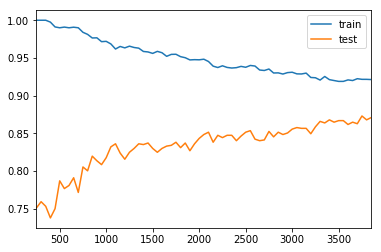

In [51]:
learning_curve_df = pd.DataFrame.from_dict(learning_curve_dict, orient="index")
learning_curve_df.columns = ['train','test']
learning_curve_df.plot()   # Regularization & getting more training data will help

In [52]:
params = {
    "feature_selector__k":(500, 750, 1000),
    "model__C":(0.03, 0.1, 0.3, 1)
}
grid_serach = GridSearchCV(pipeline, params, cv=3, scoring = "accuracy", verbose = 1)

In [53]:
%%time
grid_serach.fit(train_test_X, train_test_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 13.3min finished


Wall time: 14min 8s


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('unstructured_features', Pipeline(memory=None,
     steps=[('remarks_extractor', RemarksExtractor(factor='REMARKS', replace_num=True)), ('text_features', FeatureUnion(n_jobs=1,
       transformer_list=[('ngram_tfidf', Pipeline(memo...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'feature_selector__k': (500, 750, 1000), 'model__C': (0.03, 0.1, 0.3, 1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [54]:
grid_serach.best_params_

{'feature_selector__k': 1000, 'model__C': 0.1}

In [19]:
pipeline_reg = Pipeline([
    
    ('features', FeatureUnion([
        ('unstructured_features', Pipeline([
            ("remarks_extractor",RemarksExtractor('REMARKS', replace_num=True)),
            ("text_features", FeatureUnion([
                ("ngram_tfidf", Pipeline([            
                    ("vectorizer", TfidfVectorizer(token_pattern='(?u)\\b[a-zA-Z]+\\b', min_df=2, 
                                                   stop_words=['the','a','an'], ngram_range=(1,2), use_idf=True)),
                    ("densetranformer",DenseTransformer())
                ])),
                ("length", GetTextLen(second_order=False))
            ])) 
        ])),
        
        # Structured information
        ("is_traffic", VarExtractor('TRAFFIC')),
        ("is_hotspot", VarExtractor('HOTSPOT')),
        ("post_403"  , VarExtractor("POST403"))

    ]))   
    ,
    
    ("normalizer", preprocessing.MinMaxScaler(feature_range=[0,1])),
    ("feature_selector", SelectKBest(score_func=chi2, k=750)),
    ("model",SVC(kernel="linear", probability=True, C = 0.3))
])

In [20]:
%%time
pipeline_reg.fit(train_test_X, train_test_y)
pred_y = pipeline_reg.predict(cross_X)
print_accuracy(cross_y, pred_y)

[[508  56]
 [ 72 340]]
precision: 0.858585858586
recall: 0.825242718447
Wall time: 35.4 s


#### Eval on evaluation set - see how much the model agrees with keyword serach labeling

In [65]:
pred_y = pipeline_reg.predict(eval_df2)  
print_accuracy(eval_df2['BAD'],pred_y)
pred_y_proba = pipeline_reg.predict_proba(eval_df2)

[[344  41]
 [104 270]]
precision: 0.868167202572
recall: 0.72192513369


In [21]:
feat_selected_ind = pipeline_reg.named_steps['feature_selector'].get_support()
feat_selected_ind[-4:]

array([ True,  True,  True,  True], dtype=bool)

In [24]:
tokens = pipeline_reg.named_steps['features'].transformer_list[0][1].named_steps['text_features'].transformer_list[0][1].named_steps['vectorizer'].get_feature_names()
tokens_selected = [w for w in tokens if feat_selected_ind[tokens.index(w)]]
feat_selected = tokens_selected + ["lengh","is_traffic","is_hotspot","post403"]

In [25]:
coef_df = pd.DataFrame(pipeline_reg.named_steps['model'].coef_.T,
                       index = feat_selected, columns = ['coef'])
print(coef_df.shape)
coef_df[:2]

(750, 1)


,coef
able,0.128994
able to,0.128994


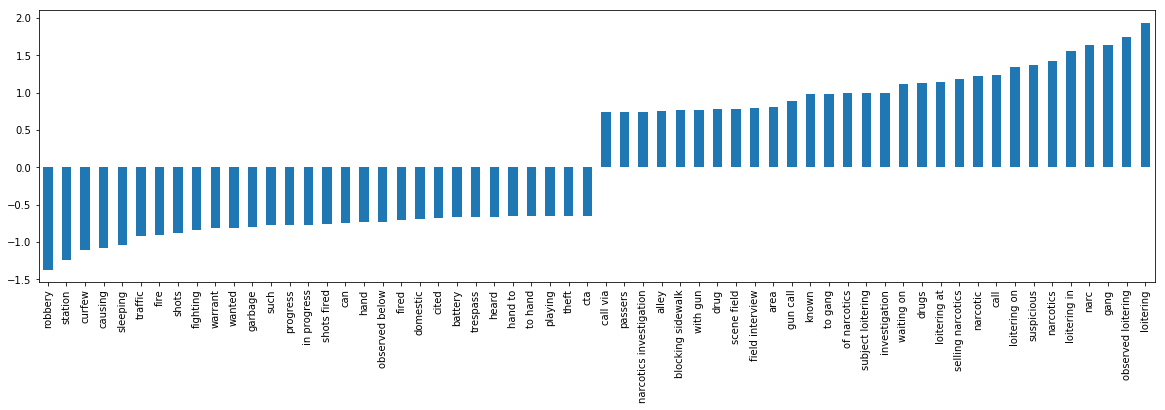

In [26]:
plot_coefs(coef_df,30)

In [83]:
pred_y_proba[:3]

array([[ 0.28884657,  0.71115343],
       [ 0.06646967,  0.93353033],
       [ 0.00473231,  0.99526769]])

In [84]:
eval_df2['Pred'] = pred_y
eval_df2['Proba'] = pred_y_proba[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [88]:
coef_df.to_excel(r"..\output\Oct 27\Features.xlsx")
# eval_df2.to_excel(r"..\output\Oct 27\Results.xlsx")